In [1]:
import variational_encoder as ve
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms


import numpy as np


In [22]:
vae = ve.VAE(checkpoint_path='model.ckpt')

Loading model from model.ckpt
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 16, 16) = 1024 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels


c:\Users\cocol\.conda\envs\ldm\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cocol\.conda\envs\ldm\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\users\cocol\documents\cours\3a\projet ia\latent-diffusion\src\taming-transformers\taming\modules\losses\lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from ./last.ckpt with 0 missing and 0 unexpected keys


c:\Users\cocol\Documents\Cours\3A\Projet IA\variational_encoder.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="c

Ignoring index file 'data.grib.5b7b6.idx' older than GRIB file


(361, 720, 3)
torch.Size([3, 361, 720])


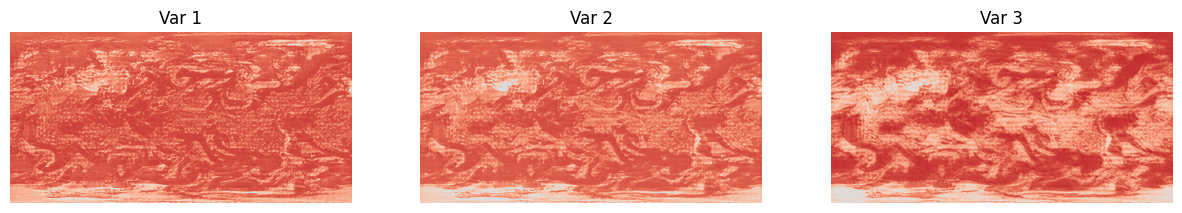

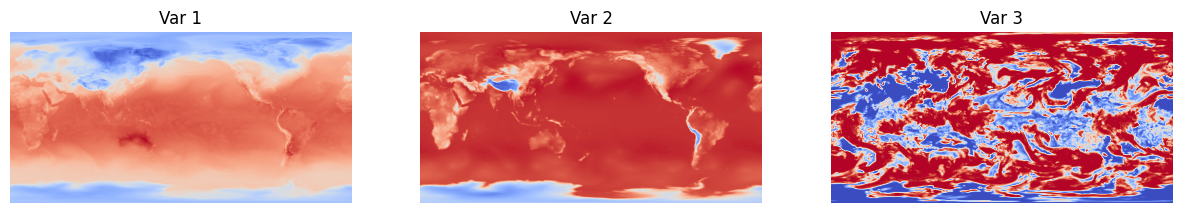

In [ ]:
# image_tensor = vae.encode_decode_image('data/1sttest/0/sim_0_time_0.png', 'test_image2.jpg', debug=True)
import data_utils
dataset = data_utils.open_grib_file("dataset.grib")


image = data_utils.load_image(dataset=dataset, sim_id=0, time_index=0)
# permute colors to 
print(image.shape)

transform = transforms.ToTensor()
input_tensor = transform(image).to('cuda')  # Shape: [C, H, W]
print(input_tensor.shape)

image_tensor = vae.encode_image(input_tensor.unsqueeze(0))
image_tensor = vae.decode_latents(image_tensor).squeeze(0)
image_tensor = image_tensor.permute(1,2, 0).cpu().numpy()

data_utils.plot_variables_from_image(image_tensor)

data_utils.plot_variables_from_image(data_utils.load_image(dataset=dataset, sim_id=0, time_index=0))


In [ ]:
image_tensor = vae.encode_decode_image('data/1sttest/0/sim_0_time_0.png', 'test_image2.jpg', debug=True)

transforms.ToPILImage()(image_tensor).show()

In [ ]:
# Fine-tuning of the VAE

# load pre-trained model
vae = ve.VAE()

# model is in vae.model

# define optimizer

optimizer = optim.Adam(vae.model.parameters(), lr=0.00001)

# define loss function






In [20]:
from torchvision import datasets

# define data loader

# make tensor and 3 channels and -1 to 1 range, Shape: [C, H, W]
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(3, 1, 1)), transforms.Lambda(lambda x: x * 2 - 1)])
dataset = datasets.MNIST(root='mnist', download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# encode decode 20 images

tensors = []

for i, (data, _) in enumerate(data_loader):
    if i == 20:
        break
    data = data.cuda()
    image_tensor = vae.model.encode(data)
    image_tensor = vae.model.decode(image_tensor[0])

    # back transform to 0 255 range and one channel
    image_tensor = (image_tensor + 1) / 2 * 255
    image_tensor = image_tensor.clamp(0, 255).byte()
    image_tensor = image_tensor[0].cpu().detach().numpy()
    image_tensor = np.expand_dims(image_tensor, 0)
    image_tensor = torch.from_numpy(image_tensor).float()

    tensors.append(image_tensor[0])
    # save image
    transforms.ToPILImage()(image_tensor[0]).save(f'../Proba/encoded_decoded_{i}.png')




In [1]:
import src.utils.data_utils as du
from torch.utils.data import DataLoader


dataset = du.open_grib_file("dataset.grib")

window_size = 5  # Nombre d'étapes temporelles par fenêtre
overlap = 1       # Chevauchement entre fenêtres

# Initialiser le dataset
image_sequence_dataset = du.ImageSequenceDataset(
    dataset=dataset,
    window_size=window_size,
    overlap=overlap,
    variables=['u10', 'v10', 't2m'],
    skip_last=True
)

# Initialiser le DataLoader
data_loader = DataLoader(
    image_sequence_dataset,
    batch_size=32,           # Nombre de fenêtres par batch
    shuffle=True,           # Mélanger les données
    num_workers=0,          # Nombre de workers pour le chargement des données
    drop_last=True          # Ignorer les batches incomplets
)

/home/ensta/ensta-lachevre/miniconda3/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/ensta/ensta-lachevre/climate-uncertainty-diffusion/src/utils/data_utils.py:200: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.total_time = dataset.dims['time']
/home/ensta/ensta-lachevre/climate-uncertainty-diffusion/src/utils/data_utils.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mappi

Preloading all data into memory - this may take a moment...


Preprocessing frames: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.35s/it]

Data preloading complete!


In [10]:
data_iter = iter(data_loader)

In [11]:
d1 = next(data_iter)

In [27]:
d1[0].shape

torch.Size([16, 5, 3, 361, 720])

In [2]:
import torchvision
import PIL
from matplotlib import pyplot as plt
from src.utils.utils import *
import src.models.variational_encoder as ve

vae = ve.VAE()

for i, (d1,d2) in enumerate(data_loader):

    truth_sample, cond_sample = d1, d2
    # Only use a subset of the batch
    truth_sample = truth_sample.to("cuda")
    cond_sample = cond_sample.to("cuda")
    
    latent_truth = encode_sequence_with_vae(vae, truth_sample).squeeze(0)
    latent_cond = encode_sequence_with_vae(vae, cond_sample).squeeze(0)
    

    truth_recon = decode_sequence_with_vae(
        vae, latent_truth.view(32, window_size, 4, 45, 90)
    )
    
    cond_recon = decode_sequence_with_vae(
        vae, latent_cond.view(32, window_size, 4, 45, 90) 
    )
    
    
    truth_frame = truth_recon[0].cpu()
    cond_frame = cond_recon[0].cpu()


    grid = torchvision.utils.make_grid(truth_frame.view(32*5, 3, 361, 720)).permute(1,2,0)
    grid2 = torchvision.utils.make_grid(truth_frame.view(32*5, 3, 361, 720)).permute(1,2,0)


    grid = (grid + 1)/2
    plt.figure(figsize=(18,10))
    plt.imshow(grid[:,:,2])
    plt.imshow(grid2[:,:,2])
    plt.show()
    plt.close()

Loading model from /home/ensta/ensta-lachevre/climate-uncertainty-diffusion/model.ckpt
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels


/home/ensta/ensta-lachevre/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ensta/ensta-lachevre/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ModelCheckpoint])` or the `torch.serialization.safe_globals([ModelCheckpoint])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
import 


dataset = du.open_grib_file(
        "/home/ensta/ensta-lachevre/climate-uncertainty-diffusion/dataset.grib"
    )

    image_sequence_dataset = du.ImageSequenceDataset(
        dataset=dataset,
        window_size=window_size,
        overlap=overlap,
        variables=["u10", "v10", "t2m"],
        skip_last=True,
    )

    # Initialiser le DataLoader
    data_loader = DataLoader(
        image_sequence_dataset,
        batch_size=batch_size,  # Nombre de fenêtres par batch
        shuffle=True,  # Mélanger les données
        num_workers=2,  # Nombre de workers pour le chargement des données
        drop_last=True,  # Ignorer les batches incomplets
    )
